In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, '/home/peter/code/projects/tradesys/')
from tradesys import *
from tradesys.nbtools import *
from tradesys.testing import *
from tradesys.tstools import time_range, timedelta

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 950M (0000:01:00.0)
Using Theano backend.


(196000/196380)
C0: 100050 C1: 96230



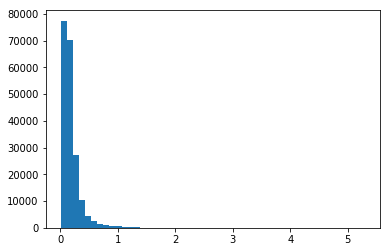

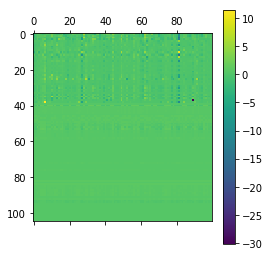

In [3]:
input_source = np.load(open('data_spy.npy','rb'))
to_predict = np.load(open('data_spy_targets.npy','rb'))

to_predict[0:5]

winlen = 1

sliding_window_jump = 1
predict_time_ahead = 1

std_winlen = 60


stds = []
hls = []
ms = []
for i in range(0, to_predict.shape[1]-std_winlen, 1):
    a = to_predict[3, i:i+std_winlen]
    h = np.max(to_predict[2, i:i+std_winlen])
    l = np.min(to_predict[3, i:i+std_winlen])
    
    mh = abs(np.max(a) - a[0])
    ml = abs(np.min(a) - a[0])
    hls.append(abs(h-l))
    ms.append(max(mh,ml))
    stds.append(np.std(a))
    
stds = array(stds)
hls = array(hls)

#stds[stds > 0.3] = 0.3

hist(stds, 50);

sp = 0.14
len(stds[stds < sp]), len(stds[stds >= sp]) 



rnd.seed(int(time.clock()*10000))

# create training set
#sep = partition_data_num(to_predict, predict_time_ahead)

x = []
y = []

c0 = []
c1 = []

for i in range(0, input_source.shape[1]-(winlen+100), sliding_window_jump):
    # form the input
    xs = input_source[:, i:i+winlen]
    #xs = scale(xs)#, axis=1)
    xs = xs.ravel()

    # form the output
    st = np.std(to_predict[3, i+winlen:i+winlen+std_winlen]) 
    
    if st < sp:
        c0.append( (xs, np.array([1, 0])) )
    else:
        c1.append( (xs, np.array([0, 1])) )
    
    if (i%1000)==0:
        clear_output(wait=True)
        print('({}/{})'.format(i, input_source.shape[1]-winlen))

print('C0: {0} C1: {1}'.format(len(c0), len(c1)))
print()

samplesize = min(len(c0), len(c1))
s1 = rnd.sample(c0, samplesize)
s2 = rnd.sample(c1, samplesize)
a = s1 + s2 
rnd.shuffle(a)
x = [x[0] for x in a]
y = [x[1] for x in a]

x = np.vstack(x)
y = np.vstack(y)





x.shape, y.shape

x.shape = (x.shape[0], -1)

x.shape

matshow(x[400:500].T); colorbar();

cutpoint = int(0.8 * x.shape[0])
x_train = x[0:cutpoint]
x_test = x[cutpoint:]
y_train = y[0:cutpoint]
y_test = y[cutpoint:]



from sklearn.ensemble import AdaBoostClassifier

# Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import sklearn as sk
import time

clf = GradientBoostingClassifier(n_estimators=100, loss='deviance')


clf.fit(x_train, argmax(y_train, axis=1))

# Here the model is saved
pkl.dump(clf, open('test.pkl','wb'))

In [4]:
clf.score(x_train, argmax(y_train, axis=1)), clf.score(x_test, argmax(y_test, axis=1))


(0.78440974747999581, 0.7813571651252208)

In [5]:
data = DataMatrix()
data.load_multicharts('../data/SPY_1_5_15_60_Minutes_01_01_10-10_31_16/SPY_1_Minute_01_01_2010-10_31_2016.txt')
data.clip_dt(DateTime(2016,1,1), DateTime(2017,1,1))

In [6]:
len(data)

99601

In [7]:
data = fill_incomplete_datamatrix(data)

data.name = 'SPY'

len(data)

81509

In [8]:
opts = BacktestOptions()
opts.commission = 0
opts.slippage = 0.0
opts.backtest_mode = BacktestMode.TRADESTATION
opts.market_open_time = Time(9,30)
opts.market_close_time = Time(16,0)

In [9]:
num_trials = 1

--------------------
Profit factor: 1.09
Trades: 476
Profit / Loss trades: 298 (62.6%) / 174 (37.4%)
Gross profit: $52545.92
Gross loss: $-48065.99
Net profit: $4479.93
Long / Short positions: 231 (48.5%) / 245 (51.5%)
--------------------

trial: 0
CPU times: user 24min 2s, sys: 5min 28s, total: 29min 31s
Wall time: 29min 31s


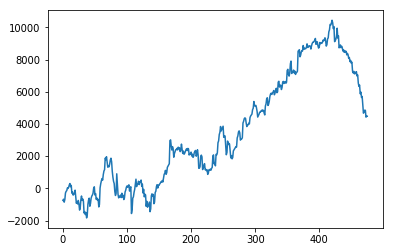

In [10]:
%%time

res = []
for trial in range(num_trials):

    s = """

    AO = MLSIGNAL(300, 1, modelname='test', datamodel='datamodel_ta', modeltype='sklearn', dolog=true, noinput=false);

    MK = AO == I(1);

    K = CURRENT_BAR % I(60);

    BO = K == I(0);

    BUY_LIMIT_AT (PRICE('close')-F({dist})) ^ BO and MK;
    SELL_LIMIT_AT (PRICE('close')+F({dist})) ^ BO and MK;

    CLOSE_IF BO;

    """.format(dist=0.05)
    
    clear_output()
    info = backtest(data, s, options=opts, plot=1, prt=1, )
    res.append(info)
    print('trial:', trial)